# Machine Learning 2022-2023 - UMONS

# Classification

In this lab we'll experiment a bit more with the classification task in order to help you get started with the project.
We'll consider several models, some of which will be covered later in the course.
We'll be using the [Wine Quality](https://archive.ics.uci.edu/ml/datasets/wine+quality) dataset, which contains several attributes of white wines.
Each observation is associated to a rating between 0 and 10 that will be the label of our classification task.

The columns of the dataframe contain the following information :
* fixed_acidity: amount of tartaric acid in g/dm^3
* volatile_acidity: amount of acetic acid in g/dm^3 
* citric_acid: amount of citric acid in g/dm^3
* residual_sugar: amount of remaining sugar after fermentation stops in g/l
* chlorides: amount of salt in wine 
* free_sulfur_dioxide: amount of free SO2
* total_sulfur_dioxide: amount of free and bound forms of SO2
* density: density of the wine
* pH: PH level of the wine on a scale from 0 to 14
* sulphates: amount of sulphates 
* alcohol: the percent of alcohol content
* quality: quality of the wine (score between 0 and 10)

**Import the necessary libraries**

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (ConfusionMatrixDisplay, accuracy_score,
                             confusion_matrix, log_loss)
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

sns.set_theme()
np.random.seed(0)

## Data exploration

**1) Read the dataset 'wine.csv' and check its properties (length, types, missing values). Handle missing values if needed.** 

In [2]:
df = pd.read_csv('data/wine.csv', sep=';')
df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [3]:
print(df.shape)
print(df.dtypes)
print(df.isna().sum())

(4898, 12)
fixed acidity           float64
volatile acidity        float64
citric acid             float64
residual sugar          float64
chlorides               float64
free sulfur dioxide     float64
total sulfur dioxide    float64
density                 float64
pH                      float64
sulphates               float64
alcohol                 float64
quality                   int64
dtype: object
fixed acidity           0
volatile acidity        0
citric acid             0
residual sugar          0
chlorides               0
free sulfur dioxide     0
total sulfur dioxide    0
density                 0
pH                      0
sulphates               0
alcohol                 0
quality                 0
dtype: int64


## Data splitting

**2) We predict the target 'quality' from all other features. Split your datasets into a training and test set following a 80/20 partition using the `train_test_split` function.**

In [4]:
ylabel = 'quality'
X = df.drop(ylabel, axis=1)
y = df[ylabel]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, test_size=0.2, shuffle=True, random_state=0
)

## Data exploration

**3) Look at the distribution of the variable 'quality' in the training set using `sns.countplot`.**

<AxesSubplot:xlabel='quality', ylabel='count'>

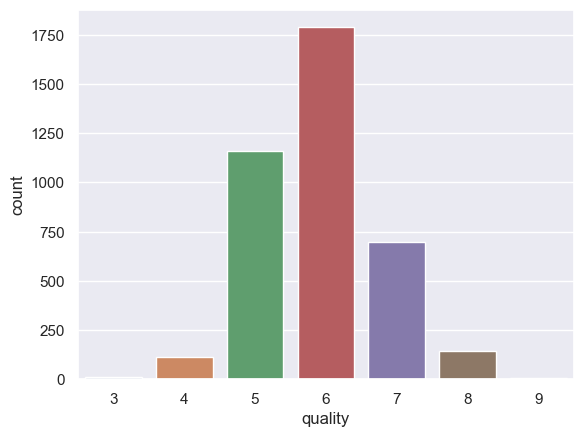

In [5]:
sns.countplot(x=y_train)

**4) For each continuous feature, plot a boxplot of this feature grouped by label values. Use the `boxplot` function of the seaborn library. Which features seem to be the most useful to predict the label 'quality'?**

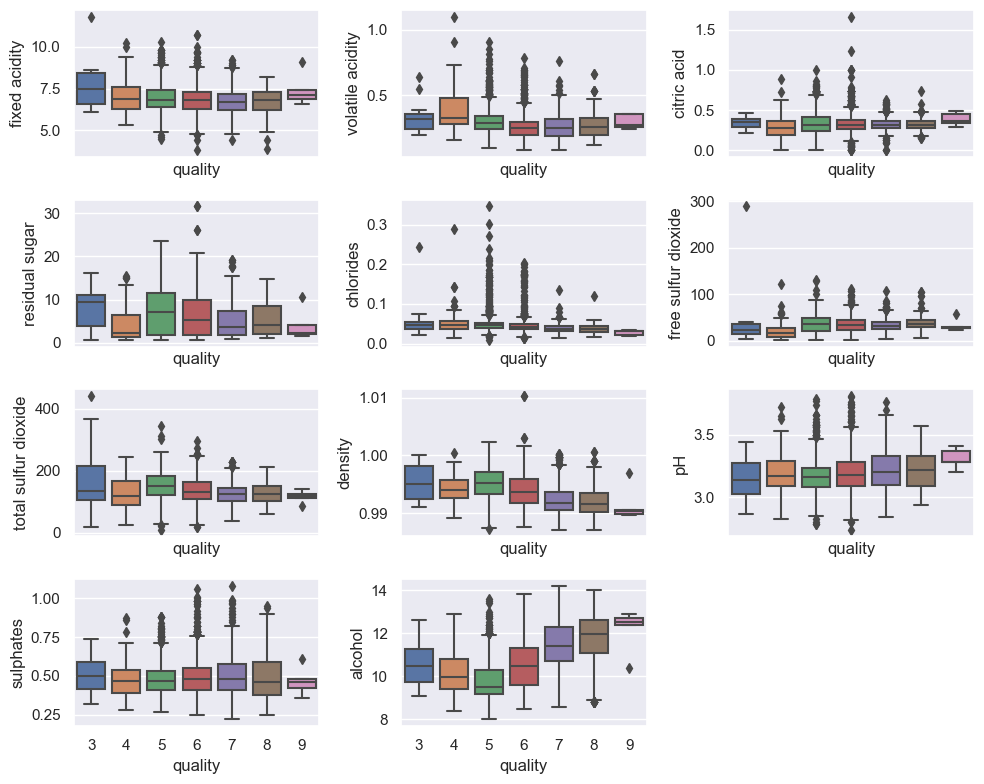

In [6]:
fig, axes = plt.subplots(4, 3, figsize=(10, 8), sharex=True)
for column, axis in zip(X_train.columns, axes.flatten()):
    sns.boxplot(x=y_train, y=X_train[column], ax=axis)
axes.flatten()[-1].set_visible(False)
fig.tight_layout()

Based on the boxplots, alcohol, density and pH seem to be the most useful features.

**5) Plot the pairwise relationship of the most useful features using the function `sns.pairplot`. Plot a different color according to the value of the variable 'quality' using the `hue` parameter. What do you observe?**

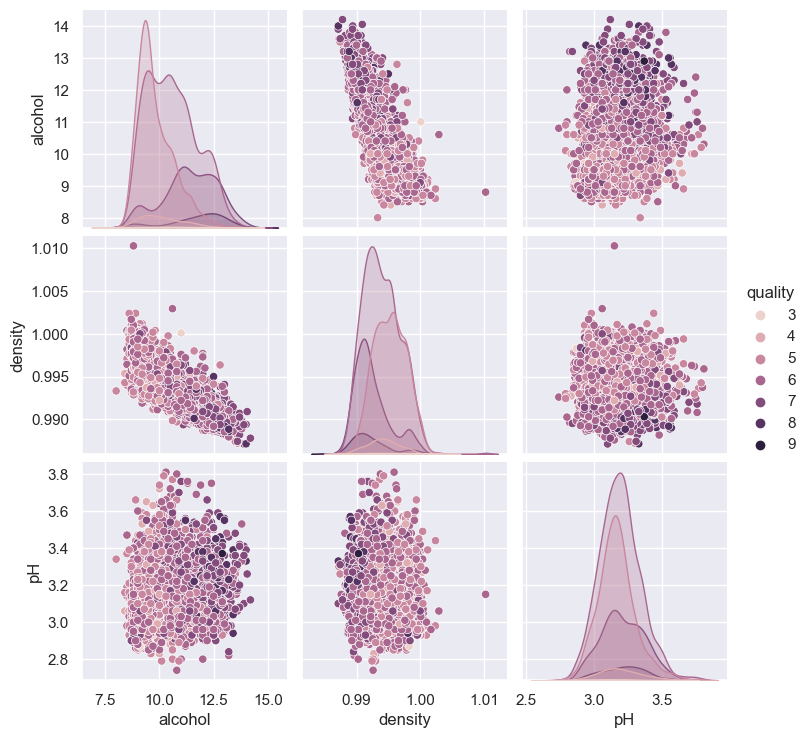

In [7]:
sns.pairplot(pd.concat([X_train[['alcohol', 'density', 'pH']], y_train], axis=1), hue='quality')

We notice that there is a negative correlation between the variables alcohol and density. There does not seem to be a clear correlation between the other variables.

## Data preprocessing

**6) Normalize the continuous features using the `StandardScaler` class. Make sure to fit it on the training dataset to avoid data leakage.**

In [8]:
# Note that there is no categorical variable to one-hot encode

# We can't look at the test set to avoid data leakage
X_scaler = StandardScaler().fit(X_train)
X_train = pd.DataFrame(X_scaler.transform(X_train), columns=X.columns)
X_test = pd.DataFrame(X_scaler.transform(X_test), columns=X.columns)

## Hyperparameter tuning

**7) For each one of the following models, create a grid of hyperparameters based on the corresponding scikit-learn documentation:**
- **KNN**
- **Gaussian Naive Bayes**
- **Linear Discriminant Analysis**
- **Logistic Regression**
- **Random Forest**
- **Gradient Boosting**

In [9]:
param_grid_knn = {
    'n_neighbors': [3, 5, 10, 20, 50, 100],
    'weights': ['uniform', 'distance'],
    'p': [1, 2],
}

param_grid_nb = {}

param_grid_lda = {}

param_grid_lr = {
    'penalty': ['l2'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100],
    'fit_intercept': [True, False],
}

param_grid_rf = {
    'criterion': ['gini', 'entropy', 'log_loss'],
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

param_grid_gb = {
    'loss': ['log_loss'],
    'learning_rate': [0.02, 0.1, 0.5],
    'n_estimators': [100, 200, 300],
    'criterion': ['friedman_mse', 'squared_error'],
    'max_depth': [None, 2, 5, 10],
}

# We additionally experiment with a logistic regression model with feature selection
param_grid_lr_skb = {
    'skb__k': [3, 5, 7, 9],
    'clf__penalty': ['l2'],
    'clf__fit_intercept': [True, False],
}

## Model fitting

**8) For each one of these models, select the hyperparameters that give the lowest log loss using the `RandomizedSearchCV` class. Compute the accuracy and log loss on the test dataset.**

**Print the best hyperparameters corresponding to each model and plot a confusion matrix using the function `confusion_matrix` and the class `ConfusionMatrixDisplay`.**

Running KNN
Accuracy: 0.6448979591836734
Log loss: 1.2682371878543592
Best hyperparameters: {'weights': 'distance', 'p': 2, 'n_neighbors': 100}


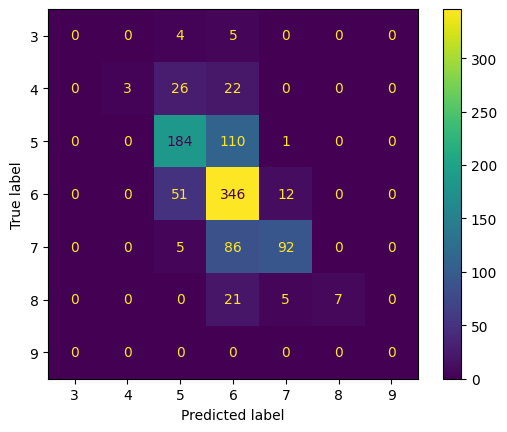

Running Naive Bayes
Accuracy: 0.4418367346938776
Log loss: 1.7270663591736533
Best hyperparameters: {}


/home/victor/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


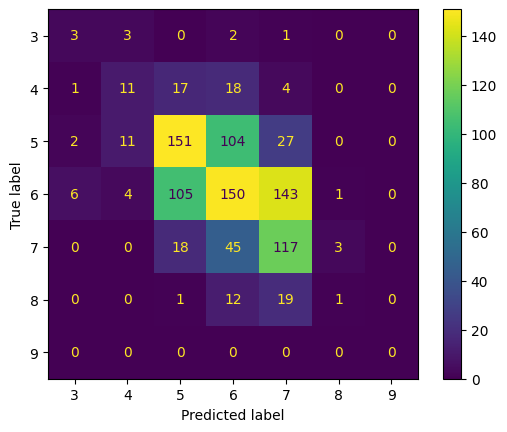

Running Linear Discriminant Analysis


/home/victor/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 1 is smaller than n_iter=10. Running 1 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy: 0.5091836734693878
Log loss: 1.2347052179437108
Best hyperparameters: {}


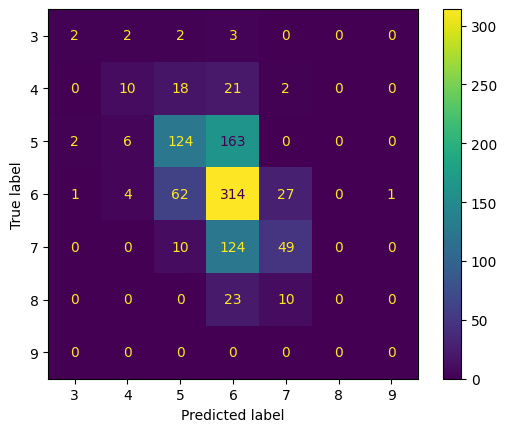

Running Logistic Regression
Accuracy: 0.5081632653061224
Log loss: 1.1736160976910217
Best hyperparameters: {'penalty': 'l2', 'fit_intercept': True, 'C': 0.1}


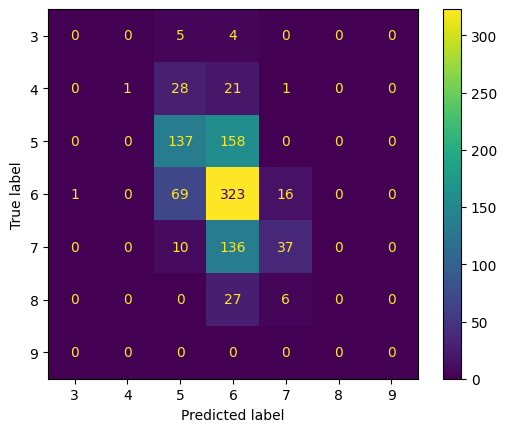

Running Logistic Regression with feature selection


/home/victor/miniconda3/lib/python3.9/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Accuracy: 0.49489795918367346
Log loss: 1.1886925795319352
Best hyperparameters: {'skb__k': 9, 'clf__penalty': 'l2', 'clf__fit_intercept': True}


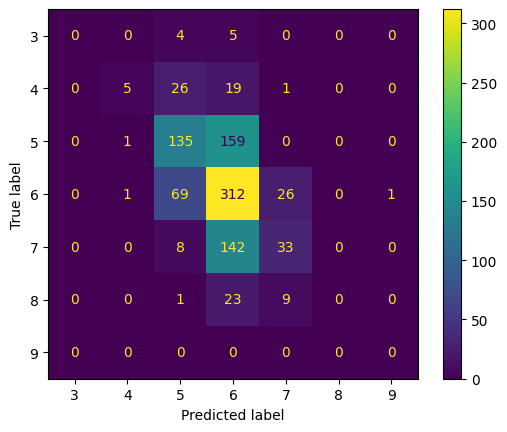

Running Random Forest
Accuracy: 0.6571428571428571
Log loss: 0.9550676458754208
Best hyperparameters: {'n_estimators': 300, 'min_samples_split': 2, 'min_samples_leaf': 1, 'max_depth': None, 'criterion': 'log_loss'}


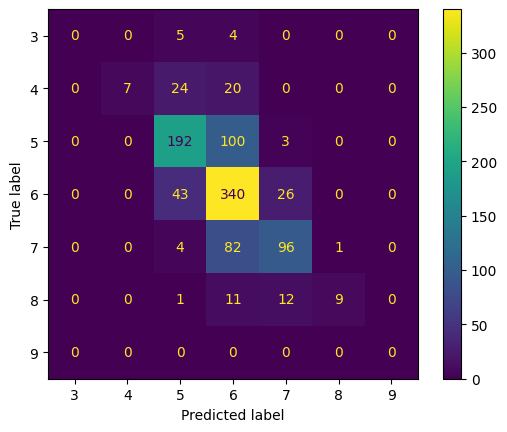

Running Gradient Boosting
Accuracy: 0.65
Log loss: 1.0425268008438497
Best hyperparameters: {'n_estimators': 100, 'max_depth': 10, 'loss': 'log_loss', 'learning_rate': 0.02, 'criterion': 'friedman_mse'}


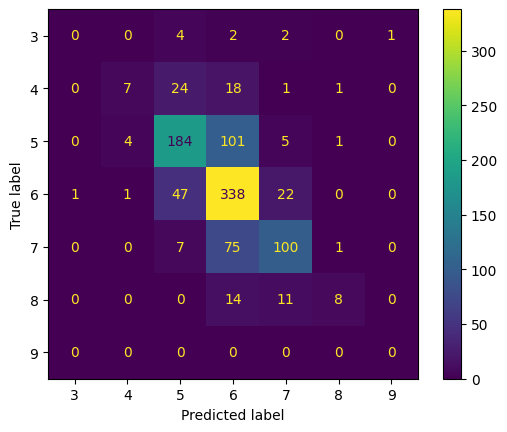

In [10]:
mpl.rc_file_defaults() # Confusion matrix plots expect matplotlib default settings

knn = KNeighborsClassifier()
nb = GaussianNB()
lda = LinearDiscriminantAnalysis()
lr = LogisticRegression(max_iter=1000)
lr_skb = Pipeline([('skb', SelectKBest()), ('clf', LogisticRegression(max_iter=1000))])
rf = RandomForestClassifier()
gb = GradientBoostingClassifier()

default_grid_params = dict(n_iter=10, cv=5, n_jobs=4)

grids = {
    'KNN': RandomizedSearchCV(knn, param_grid_knn, scoring='neg_log_loss', **default_grid_params),
    'Naive Bayes': RandomizedSearchCV(nb, param_grid_nb, scoring='neg_log_loss', **default_grid_params),
    'Linear Discriminant Analysis': RandomizedSearchCV(lda, param_grid_lda, scoring='neg_log_loss', **default_grid_params),
    'Logistic Regression': RandomizedSearchCV(lr, param_grid_lr, scoring='neg_log_loss', **default_grid_params),
    'Logistic Regression with feature selection': RandomizedSearchCV(lr_skb, param_grid_lr_skb, scoring='neg_log_loss', **default_grid_params),
    'Random Forest': RandomizedSearchCV(rf, param_grid_rf, scoring='neg_log_loss', **default_grid_params),
    'Gradient Boosting': RandomizedSearchCV(gb, param_grid_gb, scoring='neg_log_loss', **default_grid_params),
}

results = []

for model_name, model in grids.items():
    print('Running', model_name)
    # Note that by default the argument `refit` of `GridSearchCV` is set to True, so that the best estimator 
    # is refit on the whole training set.
    model.fit(X_train, y_train)

    # We measure the test accuracy and log score.
    y_pred = model.predict(X_test)
    test_accuracy = accuracy_score(y_test, y_pred)
    print('Accuracy:', test_accuracy)

    y_pred_proba = model.predict_proba(X_test)
    test_log_loss = log_loss(y_test, y_pred_proba, labels=model.classes_)
    print('Log loss:', test_log_loss)

    results.append([test_accuracy, test_log_loss])
    
    print(f'Best hyperparameters: {model.best_params_}')

    # We plot the confusion matrix
    cm = confusion_matrix(y_test, y_pred, labels=model.classes_)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_)
    disp.plot()
    plt.show()

## Test metrics

**9) Create a pandas dataframe where each row corresponds to a model. Display the accuracy and log loss computed on the test set are displayed in two columns. What are the advantages of the log loss over the accuracy?**

In [11]:
pd.DataFrame(results, columns=['Test accuracy', 'Test log loss'], index=grids.keys())

,Test accuracy,Test log loss
KNN,0.644898,1.268237
Naive Bayes,0.441837,1.727066
Linear Discriminant Analysis,0.509184,1.234705
Logistic Regression,0.508163,1.173616
Logistic Regression with feature selection,0.494898,1.188693
Random Forest,0.657143,0.955068
Gradient Boosting,0.650000,1.042527


We observe that Random Forest, Gradient Boosting, and KNN obtain the best accuracy.
Random Forest and Gradient Boosting obtain the best log score.
Note that, on this dataset, KNN has a good accuracy, but its probabilistic predictions are quite poor, as indicated by the log loss.

**What are the advantages of the log loss over the accuracy?**

Consider a classification problem where the output variable $Y \in \Set{1, \dots, K}$ can belong to $K$ classes.

Suppose that the model returns a predicted class $\hat{Y} \in \Set{1, \dots, K}$.
The accuracy for one sample is given by $\text{accuracy}(Y, \hat{Y}) = \mathbb{1}(\hat{Y} = Y)$.
It will be maximized if the model always predicts the correct label.

Suppose that the model returns a vector of probabilities $\mathbf{p} \in [0, 1]^K$.
The log loss for one sample is given by $L_\text{log}(Y, \mathbf{p}) = -\log \mathbf{p}_Y$.
Remember from the course (slide 21 of lecture 3) that $\argmin_{\theta \in \Theta} \mathbb{E}[-\log p(Y; \theta)] = \argmin_{\theta \in \Theta} \text{KL}(p_\theta, p)$.
In expectation, the log loss will be minimized when the model always predicts the correct vector of probabilities.